<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/split_recording.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Dzielenie na próbki, zapis

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
!pip install librosa
!pip install -q spectrum
!pip install pkgconfig libtfr
import libtfr
import librosa
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

source = "drive/My Drive/nagrania_probne/"
source_out = "drive/My Drive/nagrania_probne/balanced/"
nazwa = "1swierszcze_nakladki_BUK4_20160925_204604"
name = "1swierszcze_nakladki_BUK4_20160925_204604.wav"
name_txt = "1swierszcze_nakladki_BUK4_20160925_204604dot.txt"
name_out = "_all"

In [0]:
#### Parametry ####
chunk_length_ms = 500
chunk_overlap = 150
bit_rate = 16
###################

fs, data = wavfile.read(source + name)

myaudio = audiosegment.from_file(source + name)
channel_count = myaudio.channels    #Get channels
sample_width = myaudio.sample_width #Get sample width
duration_in_ms = len(myaudio) #Length of audio in ms
sample_rate = myaudio.frame_rate
nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)


########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)

y_read = pd.read_csv(source + name_txt,  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
y_read_cleanedA = y_read[y_read['bird']!= 't']  # deleted 't'
y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
#print(y_read_cleaned)
y_read = y_read_cleaned

In [0]:
#wav_file_size = (sample_rate * bit_rate * channel_count * duration_in_ms / 1000) / 8

#### Parametry ####
plot = 0               # czy wyrysowywać głosy wszystkie
plot_repr = 1
play_sound = 1
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maxymala częstotliwość analizowana ze spektro
f_min2 = 4000           # minimalna częstotliwość analizowana ze spektro
f_max2 = 9500           # maxymala częstotliwość analizowana ze spektro
n_mels = 60
n_mels2 = 80
step = 150
###################

def get_logmelspec_settings():
    logmelspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}
    return logmelspec_settings
  
def get_spec_settings():
    logspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}
    return logspec_settings  



def representations(frame):

   
      ####### reprezentacja 1 - spektrogram
      global amplitudes, freqs, times, freqs2, times2,result1, result2, result3, result4, result5, ukybirddet_spectrogram, samples_float,stft1, stft2
      
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      audio = np.array(samples_float)
      
      logspec_settings = get_spec_settings()
      stft = librosa.stft(
          audio,
          n_fft=logspec_settings["n_fft"],
          win_length=logspec_settings["win_length"],
          hop_length=logspec_settings["hop_length"],
          window=logspec_settings["window"]) 
      stft1 = amplitude_to_db(np.abs(stft)**2)
      freqs = librosa.core.fft_frequencies(n_fft=logspec_settings["n_fft"], sr=44100)
      fmin =  min(freqs[(freqs >= f_min)])
      i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
      j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
      print(np.shape(stft1),min(i),max(j))
      stft1 = stft1[min(i):max(j),]
      print(np.shape(stft1))

      
      
      #freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
      #amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
      #freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]      
      #return (amplitudes, freqs, times,ss)
      
      ####### reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula
      
      waveform = librosa.resample(np.array(samples_float), 44100, 22050)
      stft2 = librosa.stft(
          waveform,
          n_fft=1024,
          win_length=1024,
          hop_length=315,
          window=logspec_settings["window"]) 
      stft2 = amplitude_to_db(np.abs(stft2)**2)  
      freqs2 = librosa.core.fft_frequencies(n_fft=1024, sr=22050)
      i,  = np.where( freqs2 >= min(freqs2[(freqs2 >= 50)]))
      j,  = np.where( freqs2 <= max(freqs2[(freqs2 <= 11000)]))
      print(np.shape(stft2),min(i),max(j))
      stft2 = stft2[min(i):max(j),]

      
      '''
      freqs2 = librosa.core.fft_frequencies(n_fft=1024, sr=44100)
      i,  = np.where( freqs2 >= min(freqs2[(freqs2 >= 50)]))
      j,  = np.where( freqs2 <= max(freqs2[(freqs2 <= 11000)]))
      print(np.shape(stft2),min(i),max(j))
      stft2 = stft2[min(i):max(j),]
      print(np.shape(stft2))
      
      
      freqs2, times2, result2 = frame.spectrogram(window_length_samples=1024, overlap=0.5)
      result2 = result2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
      freqs2 = freqs2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
      '''
      ####### reprezentacja 3 - mel spektrogram
      ##  logmelspec_settings = {"fmin": 2000,"fmax": 11025,"hop_length": 32,"n_fft": 1024,
      ##  "n_mels": 128, "sr": 22050, "win_length": 256, "window": "hann"} za https://github.com/BirdVox/bv_context_adaptation/blob/master/src/localmodule.py
      
      logmelspec_settings = get_logmelspec_settings()
      
      ## Resample to 22050 Hz.
      
      
      #waveform = librosa.resample(np.array(samples_float), 44100, logmelspec_settings["sr"])
      #waveform = librosa.resample(frame, 44100, logmelspec_settings["sr"])
      print(type(waveform))

      # Compute Short-Term Fourier Transform (STFT).
      stft = librosa.stft(
          np.array(samples_float),
          n_fft=logmelspec_settings["n_fft"],
          win_length=logmelspec_settings["win_length"],
          hop_length=logmelspec_settings["hop_length"],
          window=logmelspec_settings["window"])

      # Compute squared magnitude coefficients.
      abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)
      abs3_stft = np.abs(stft)**2

      # Gather frequency bins according to the Mel scale.
      melspec = librosa.feature.melspectrogram(
          y=None,
          S=abs2_stft,
          sr=logmelspec_settings["sr"],
          n_fft=logmelspec_settings["n_fft"],
          n_mels=logmelspec_settings["n_mels"],
          htk=True,
          fmin=logmelspec_settings["fmin"],
          fmax=logmelspec_settings["fmax"])     
      
      # Apply pointwise base-10 logarithm.
      logmelspec = 0.5 * librosa.amplitude_to_db(melspec, ref=1.0)

      # Convert to single floating-point precision.
      logmelspec = logmelspec.astype('float32')
      result3 = logmelspec

      
      ## przerzucenie typu danych z audioframe na próbki, czy ok? nie wiem
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      
      #result3 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
            
      ####### reprezentacja 4 - mel spektrogram więcej filtrów
      result4 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels2, fmin = 4000, fmax=9500, hop_length=512, n_fft=512)
      result4 = 0.5 * librosa.amplitude_to_db(result4, ref=1.0)
      
      ####### reprezentacja 5 - multitaper
      
      #result5 = libtfr.tfr_spec(samples_float, N = 512, step = 30, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      result5 = libtfr.tfr_spec(audio, N = 512, step = 355, Np = 512, K =2, tm = 1, flock =0.1, tlock = 10)
      freqs, ind = libtfr.fgrid(fs, 512, fpass=(4000,9500)) 
      result5 = result5[ind,]; # tylko interesujące nas pasmo
      
      
      ####### reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      #audio = librosa.load(samples_float, sr = 44100)[0]
      audio = librosa.resample(samples_float, 44100, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      ####### reprezentacja 7 def get_pcen_settings(): pcen_settings = { "fmin": 2000,"fmax": 11025,"hop_length": 32,
      ## "n_fft": 1024,"n_mels": 128,"pcen_delta_denominator": 10,"pcen_time_constant_frames": 40,"pcen_norm_exponent": -0.8,
      ## "pcen_power": 0.25,"sr": 22050,"win_length": 256,"window": "hann"} return pcen_settings
      
      ####### reprezentacja 8: falki?
      librosa.display.specshow(result5,cmap="jet", x_axis='time')      
      
      if plot_repr == 1:
        '''
        
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.title('Spect1')
        plt.show()
        '''
        result1 = stft1
        plt.subplot(3,2,1)
        librosa.display.specshow(stft1, cmap="jet", sr=44100)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect1')
        #plt.xlim([0, 0.5])
        #plt.ylim([0, 10000])
        #plt.colorbar(format='%+2.0f dB')
        
        result2 = stft2
        plt.subplot(3,2,2)
        librosa.display.specshow(stft2, cmap="jet", sr=22050)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect2 bulbul')
                
        '''
        result2 = 10 * np.log10(result2 + 1e-9)
        plt.pcolormesh(times2, freqs2, result2, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.title('Spect2')
        plt.show()
        '''
        
        plt.subplot(3,2,3)
        librosa.display.specshow(result3,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        #plt.imshow(result3, cmap="jet")
        plt.title('Melspect1')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(3,2,4)
        librosa.display.specshow(result4,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        plt.title('Melspect2')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(3,2,5)
        librosa.display.specshow(result5,cmap="jet", x_axis='time')
        #librosa.display.specshow(result5[40:90],x_axis='time')
        #plt.imshow(result5, cmap="jet")
        plt.title('Multitaper')
                
        plt.subplot(3,2,6)             
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        #plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
        plt.show()
        #plt.tight_layout()
        
        
        
      if play_sound ==1:
        
        ipd.Audio(samples_float,rate=44100)
      


In [0]:
#@title
i = 1
frame_start = i*(chunk_length_ms - chunk_overlap)
frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
frame = myaudio[frame_start : frame_end]
frame2 = myaudio[0:4000]
!pip install ffmpeg-python

from pydub.playback import play
import ffmpeg
#from ffmpeg import ffplay
print("This should be playing music.")
play(frame2)
print("It has now played music")
from IPython.display import Audio
#Audio(frame2)

s = Sound() 
s.read(frame) 
s.play()
#waveform = librosa.resample(frame, 44100, logmelspec_settings["sr"])
#print(type(waveform))


In [0]:
#@title
import IPython.display as ipd
samples = frame.get_array_of_samples()
samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
ipd.Audio(samples_float,rate=44100)

In [0]:
#@title
samples = frame.get_array_of_samples()
samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
print(type(frame))
print(type(samples))
waveform = librosa.resample(np.array(samples_float), 44100, logmelspec_settings["sr"])
#audio = librosa.core.load(samples_float, sr=44100)[0]
result3 = librosa.feature.melspectrogram(y=np.array(samples_float), sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
print(type(result3))
#a, b, c, d = representations(frame) 
#representations(frame) 
#print(amplitudes)


In [0]:
#@title
 ## reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula
      freqs2, times2, result2 = frame.spectrogram(window_length_samples=1024, overlap=0.5)
      result2 = result2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
      freqs2 = freqs2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
    
      ## reprezentacja 3 - mel spektrogram
      result3 = librosa.feature.melspectrogram(y=frame, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
      
      ## reprezentacja 4 - mel spektrogram więcej filtrów
      result4 = librosa.feature.melspectrogram(y=frame, sr=44100, n_mels= n_mels2, fmin = 4000, fmax=9500)
      
      ## reprezentacja 5 - multitaper
      
      result5 = libtfr.tfr_spec(frame, N = 512, step = 100, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      
      ## reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      audio = librosa.load(frame, sr = 44100)[0]
      audio = librosa.resample(audio, sr, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      if plot_repr == 1:
        
        plt.subplot(2,3,1)
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
        
        plt.subplot(232)
        amplitudes2 = 10 * np.log10(amplitudes2 + 1e-9)
        plt.pcolormesh(times2, freqs2, amplitudes2, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
        
        
        plt.subplot(233)
        plt.imshow(result3, cmap="jet")
        
        plt.subplot(234)
        plt.imshow(result4, cmap="jet")
        
        plt.subplot(235)
        plt.imshow(result5, cmap="jet")
        
        plt.subplot(236)             
        plt.show()
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
        plt.tight_layout()


(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


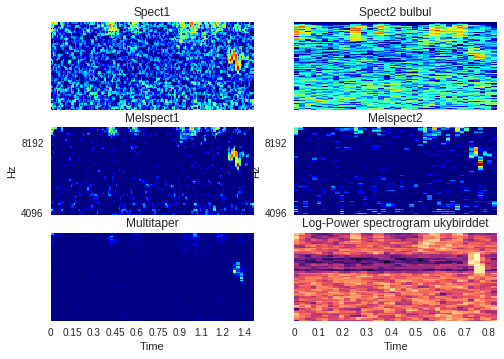

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


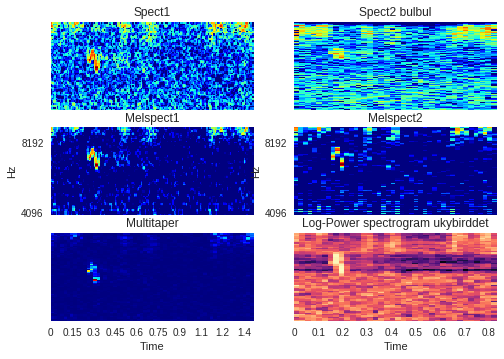

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


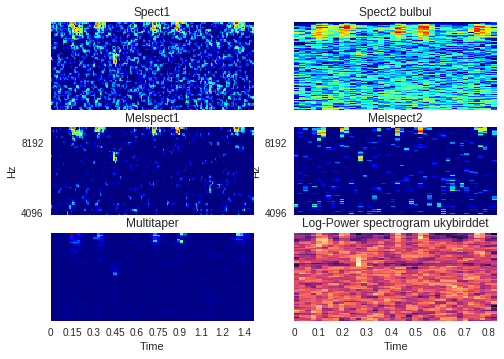

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


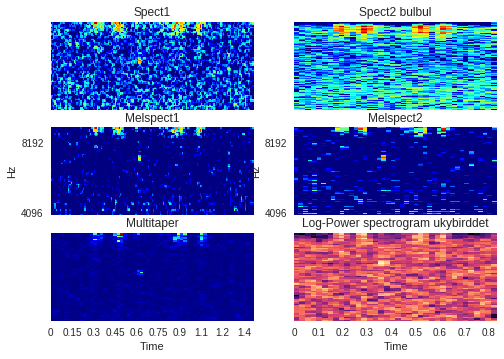

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


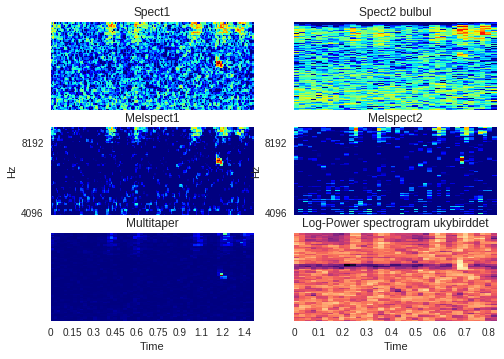

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


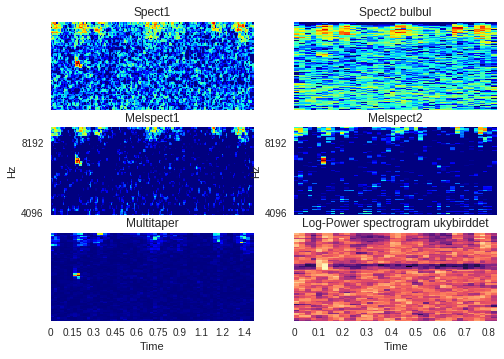

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


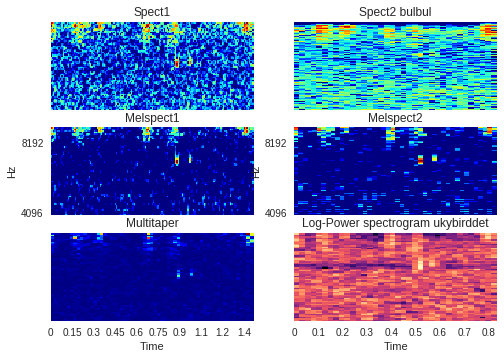

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


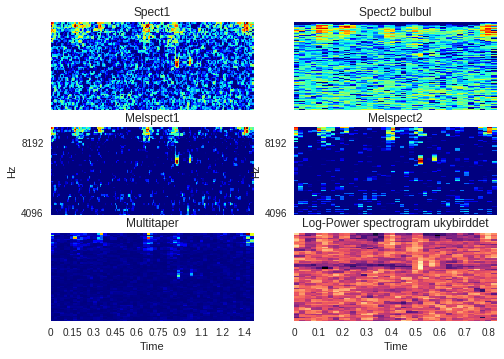

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


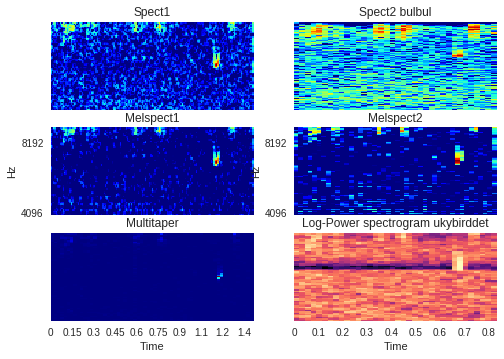

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


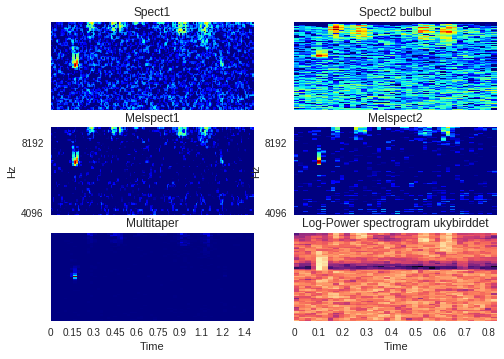

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


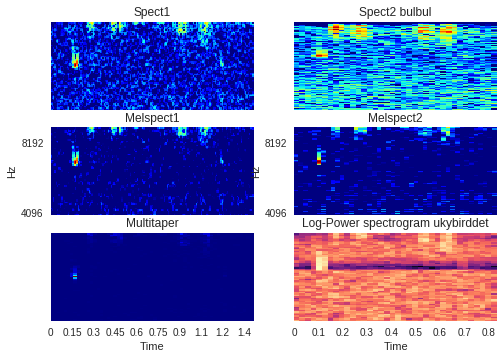

(257, 148) 47 110
(63, 148)
(513, 36) 3 510
<class 'numpy.ndarray'>


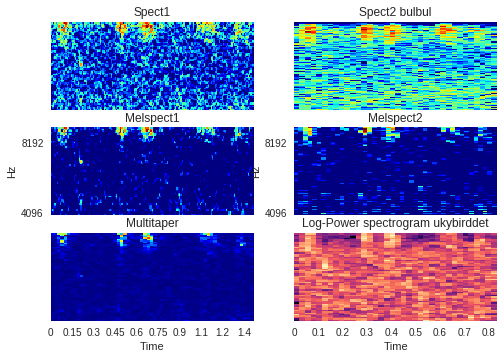

1:(63, 148)
2:(507, 36)
3:(60, 148)
4:(80, 44)
5:(64, 61)
6:(60, 36)


In [142]:
########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek
import librosa
from librosa import display
from librosa.core import power_to_db
from librosa.core import amplitude_to_db
import IPython.display as ipd

image_positive = []
description_positive = []
sum_birds=0
has_bird = 1

for i in range(500,700): #math.floor(nr_of_chunks)): 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  x = range(frame_start,frame_end)
  
  for j in y_read.index.tolist():
    bird_start = int(round(y_read.start[j]*1000))
    bird_end = int(round(y_read.end[j]*1000))
    y = range(bird_start,bird_end)
    
    intersect_start = max(x[0], y[0])
    intersect_end = min(x[-1], y[-1])+1
    range1 = (range(intersect_start, intersect_end))
    
    if len(range1)> minimal_duration: 
      sum_birds = sum_birds+1
      representations(frame)  
      
      #image_positive.append(amplitudes)
      description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])

        
print("1:" + str(np.shape(result1)))
print("2:" + str(np.shape(result2)))         
print("3:" + str(np.shape(result3)))
print("4:" + str(np.shape(result4))) 
print("5:" + str(np.shape(result5)))
print("6:" + str(np.shape(ukybirddet_spectrogram)))

ipd.Audio(samples_float,rate=44100)



In [0]:
#@title
librosa.display.specshow(stft2, cmap="jet", sr=22050)
        #plt.imshow(result3, cmap="jet")
plt.title('Spect1')
#aaa = stft1[:,5:15]
print(np.shape(stft2))
freqs2 = librosa.core.fft_frequencies(n_fft=1024, sr=22050)
i,  = np.where( freqs2 >= min(freqs2[(freqs2 >= 50)]))
j,  = np.where( freqs2 <= max(freqs2[(freqs2 <= 11000)]))
print(np.shape(stft2),min(i),max(j))
stft3 = stft2[min(i):max(j),]
print(np.shape(stft3))
librosa.display.specshow(stft3, cmap="jet", sr=22050)


In [0]:
#@title
#freqs.index(min(freqs[(freqs >= f_min)]))
fmin =  min(freqs[(freqs >= f_min)])
print((freqs))
#np.where([1,2,3], fmin)
i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
print(min(i))
print(freqs[min(i)])
j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
print(max(j))
print(freqs[max(j)])

In [0]:

########## Usunięcie duplikatów, zakładamy że nie więcej niż 2 głosy w ramce

labels = ['Chunk_nr', 'Chunk_start', 'Chunk_end', 'Call_start_chunk','Call_end_chunk','Call_start','Call_end','Has_bird','2nd_call_start','2nd_call_end']
description_pd = pd.DataFrame.from_records(description_positive, columns=labels)   # na lepszy format

duplic = description_pd[description_pd.duplicated(subset='Chunk_nr',keep=False)]   # wypisanie duplikujących sie ramek (ale z innym glosem zawartym)
duplic_index = duplic.drop_duplicates(subset='Chunk_nr',keep='first')['Chunk_nr'].index.tolist() 
#print(duplic)
#print(duplic_index)

df = description_pd.drop_duplicates(subset='Chunk_nr',keep='first')  # usuwamy drugie duplikaty z listy
for i in duplic_index:
  df['2nd_call_start'][i]= description_pd['Call_start'][i+1]   # dopisujemy drugi głos do ramki
  df['2nd_call_end'][i]= description_pd['Call_end'][i+1]

########## Macierz wyjściowa obrazów i opisów, same ptaki
  
description_positive_no_duplic = df  
image_positive_no_duplic = np.delete(image_positive, (duplic_index), axis=0)
print(np.shape(image_positive_no_duplic))
print((description_positive_no_duplic))

In [0]:
########## Indexy pustych ramek
random.seed(667)
sum_birds = np.shape(image_positive_no_duplic)[0]  # bez powtórzeń już

birds_chunks = description_positive_no_duplic['Chunk_nr'].tolist()
range_nonbirds = [i for i in range(0, math.floor(nr_of_chunks)) if i not in birds_chunks]
nobirds_chunks = random.sample(range_nonbirds, sum_birds)  # dobieramy tyle ramek bez ptaków, co mamy z ptakami
#print(nobirds_chunks)

In [0]:
########## Utworzenie macierzy z ramkami bez ptaków
image_negative = []
description_negative = []

for i in nobirds_chunks: 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  #print(frame_start,frame_end)
  x = range(frame_start,frame_end)

  ## reprezentacja 1 - spektrogram
  freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
  amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
  freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]
      
  image_negative.append(amplitudes)
  description_negative.append([i, frame_start, frame_end, 0, 0, 0, 0, 0, 0, 0])
        
#print(description_negative[:3])
#print(np.shape(description_negative))
#print(np.shape(image_negative))  

In [0]:
########## Złożenie dwóch macierzy i zapis
description_negative_pd = pd.DataFrame.from_records(description_negative, columns=labels)

final_dataset = np.concatenate([image_positive_no_duplic, np.array(image_negative)])
final_description = pd.concat([description_positive_no_duplic,description_negative_pd])

np.save((source_out + nazwa + 'balanced_dataset' ),final_dataset)
np.savez((source_out + nazwa + 'all' ),final_dataset=final_dataset,final_description=final_description, freqs=freqs, times= times, nobirds_chunks=nobirds_chunks)

Chunk_nr               692
Chunk_start         242200
Chunk_end           242700
Call_start_chunk    242251
Call_end_chunk      242273
Call_start          242251
Call_end            242273
Has_bird                 1
2nd_call_start      242618
2nd_call_end        242633
Name: 19, dtype: int64


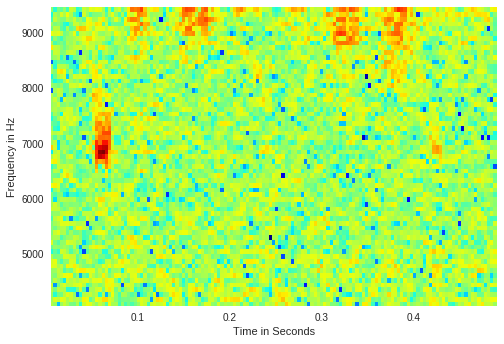

Chunk_nr              1202
Chunk_start         420700
Chunk_end           421200
Call_start_chunk         0
Call_end_chunk           0
Call_start               0
Call_end                 0
Has_bird                 0
2nd_call_start           0
2nd_call_end             0
Name: 121, dtype: int64


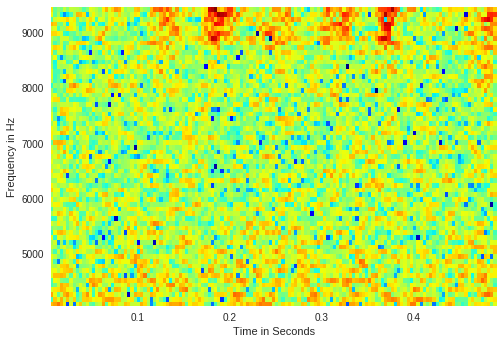

In [0]:
########## Przykład, z ptakiem i bez ptaka
for i in (18, 245):  
  print(final_description.iloc[i])  
  amplitudes = 10 * np.log10(final_dataset[i] + 1e-9)
  plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
  plt.xlabel("Time in Seconds")
  plt.ylabel("Frequency in Hz")
  plt.show()

In [0]:
########## Przykład jak ładować dane

dane1 = np.load(source_out + nazwa + 'balanced_dataset.npy')
opisy1 = np.load(source_out + nazwa + nazwa_out + '.npz' )
fre = opisy1['freqs']
#print(opisy1.files)
#print(fre)


In [0]:
# pięć różnych reprezentacji

# 1. zwykłe spektro
# 2. multitaper